<a href="https://colab.research.google.com/github/Luciahelenasantos/Deep_Learning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Descrição do problema***

Sendo de interesse controlar a emissão de poluentes na atemosfera, a identificação e localização de locais onde estejam ocorrendo queimadas torna-se uma investigação relevante, assim este trabalho tem como objetivo resolver um problema computacional através do treinamento de um modelo deep learning de aprendizado profundo em problema de linguagem visual de classificação binária.

Através da plataforma Kaggle, que oferece conjunto de dados públicos para uso em estudos, foi encontrado o banco de dados onde são apresentadas imagens com presença ou ausência de incêndio, sendo as hipóteses verificadas "Com fogo" ou "Sem fogo". O banco utilizado "wildfire-smoke" apresenta também imagens de incêndio florestal.

Os dados já encontram-se divididos três diretórios onde são dispostos dados para treinamento denominado "*train*", teste denominado "*test*" e validação denominado "*valid*". Em cada diretório existe um arquivo csv "*_annotations.csv*" e as imagens em formato e extensão ".jpg"





## Dicionário de dados:



O arquivo csv possui os seguintes atributos:
##### - **filename:** Nome de identificação da imagem

#--#
Os valores a seguir referem-se às coordenadas de delimitação de cada objeto identificado e rotulado nas imagens representando uma instância de fumaça de incêndio florestal detectada. O box representa a caixa delimitadora da imagem
##### - **width:** Data e horário de medição do poluente pela estação
##### - **height:** Sigla da estação meteorológica Irajá (IR)
##### - **class:** Sigla da estação meteorológica Irajá (IR)
##### - **xmin:** Representa a coordenada x (horizontal) do canto superior esquerdo, o ponto mais à esquerda do box.
##### - **ymin:** Representa a coordenada y (vertical) do canto superior esquerdo, o ponto mais acima do box.
##### - **xmax:** Representa a coordenada x (horizontal) do canto inferior direito, o ponto mais à direita do box.
##### - **ymax:** Representa a coordenada y (vertical) do canto inferior direito, o ponto mais abaixo do box.

Os link's abaixo representam locais onde é possível fazer o download do banco utilizado, e onde na plataforma GitHub é encontrada descrição mais detalhada.



https://public.roboflow.com/object-detection/wildfire-smoke/1



https://github.com/aiformankind/wildfire-smoke-dataset

# ***1. Importando as bibliotecas necessárias para executar o notebook***

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # para uso de imagens
import sklearn.metrics as skm
import itertools
import gdown
import zipfile
from google.colab import drive # acesso ao drive do google Colab - 'drive.mount'
from sklearn.model_selection import train_test_split # para divisão de treino e teste
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')

# ***2. Funções necessárias para executar o notebook***

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=360)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

# ***3. Acessando e tratando os dados que serão a entrada do modelo de deep learning***

In [4]:
file_id = "1k9ma-scSjB4lkuorIhGVPm0hYPeq09ye"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/Fire_detection.v4i.tensorflow"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1k9ma-scSjB4lkuorIhGVPm0hYPeq09ye
To: /content/dataset/Fire_detection.v4i.tensorflow
100%|██████████| 26.5M/26.5M [00:00<00:00, 76.8MB/s]


'dataset/Fire_detection.v4i.tensorflow'

Nas células de código a seguir são apresentados os caminhos onde os arquivos de treino, teste e validação serão encontrados no Notebood Colab.

In [5]:
destination = 'dataset/' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [6]:
# Acessando o diretório das imagens

r = 'dataset/train/'
print(os.listdir(r))

['ck0t3r291z3xb0a46a6hx1rak_jpeg_jpg.rf.04753c08ed8863bce57113ed83a2ae2f.jpg', 'ck0kmem9m68vr07947lx0jam1_jpeg_jpg.rf.322ea931b63d664ba4a3e59dbbc511c1.jpg', 'ck0uk2i9z86xl0a46gizlif59_jpeg_jpg.rf.4db6ccb4e5f33d0a43da9651a1089cd3.jpg', 'ck0kl0ifc5xd60863hxynsup8_jpeg_jpg.rf.7cffae6027f32be5a9e1d9d7eac05d54.jpg', 'ck0u0l462sqjj0863jgtyd84b_jpeg_jpg.rf.7cdde27f0ec2cbaae6c1046231c2f6cf.jpg', 'ck0ow39yt6j650a4633r8lu2g_jpeg_jpg.rf.30f710a451dc40f3adcc4b3f2837b691.jpg', 'img_631_jpg.rf.d56fab4a377814b835f8f7b5465fc1e8.jpg', 'ck0tyxvkx6t1d0848kk4vfkrb_jpeg_jpg.rf.2ac2c28eb2a840beb5bb4152a76b9ff1.jpg', 'img_625_jpg.rf.c7fc852627f83df944bcce46547f8b16.jpg', 'img_770_jpg.rf.f68c23cf1c75790376a3bffbcd7fced9.jpg', 'ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.39183a5a3e65727f48cb39a0c1203dc7.jpg', 'ck0ukgesfwh7f0944smkfpncd_jpeg_jpg.rf.83ab395d79abdad978d1525effc7ae10.jpg', 'ck0rp95tf2vg70794wbjk2kk3_jpeg_jpg.rf.852fc6f60aa42f1ac04fe8ea07109902.jpg', 'ck0kmp3qy67dy08634jubsyx8_jpeg_jpg.rf.6c62ba6aaf61806

In [7]:
# Lendo o arquivo csv com as informações das imagens

df = pd.read_csv('dataset/train/_annotations.csv', delimiter = ',')

In [8]:
# Verificação dos dados no dataset df

df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...,448,448,0,267,198,428,266
1,img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...,448,448,0,112,135,384,427
2,ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...,448,448,0,70,146,288,285
3,ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...,448,448,0,270,202,326,231
4,ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...,448,448,0,49,147,284,289
...,...,...,...,...,...,...,...,...
859,ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...,448,448,0,105,192,145,210
860,ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...,448,448,0,1,105,105,311
861,ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...,448,448,0,136,194,149,215
862,ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...,448,448,0,117,241,136,259


# ***4. Pré-processamento dos dados***

Analisando o arquivo csv com os dados foi possível identificar nomes duplicados de imagens, tal situação pode resultar em problemas na implementação do modelo. Problemas como atribuição de maior pesos à estas imagens duplicadas, pode levar a uma representação distorcida dos dados, assim como afetar a capacidade do modelo de generalizar novas imagens, ou seja, afetar a capacidade do modelo fazer previsões ou classificações precisas e corretas em dados de entrada que não foram utilizados durante o treinamento.

A duplicidade pode também trazer o risco de ocorre Overfiting, ou seja, trazer uma situação onde o modelo se ajusta excessivamente aos dados de treinamento, possibilitando que o modelo aprenda a memorizar as duplicatas, levando o mesmo a uma baixa capacidade de generalização para novos dados. Inicialmente no banco df existem 864 imagens, tal número sofrerá uma redução em função da retirada das duplicidades.

##4.1 - Tratando dados para treinamento

In [9]:
# Verificar registros duplicados para o atributo "filename"

atributo = "filename"
registros_duplicados = df.duplicated(subset=atributo, keep=False)

dados_duplicados_tr = ''

if registros_duplicados.any():
    print("Existem registros duplicados para o atributo", atributo)

    dataset_duplicados = df.loc[registros_duplicados]

    dados_duplicados_tr = 'Sim'
else:
    print("Não existem registros duplicados para o atributo", atributo)

Existem registros duplicados para o atributo filename


In [10]:
# Apresentando os dados com duplicidade

if dados_duplicados_tr == 'Sim':
  print(dataset_duplicados)

                                              filename  width  height  class  \
14   img_631_jpg.rf.d56fab4a377814b835f8f7b5465fc1e...    448     448      0   
15   img_631_jpg.rf.d56fab4a377814b835f8f7b5465fc1e...    448     448      1   
34   img_634_jpg.rf.db03b0580776dced252e5fc01b0d83d...    448     448      1   
35   img_634_jpg.rf.db03b0580776dced252e5fc01b0d83d...    448     448      0   
38   img_650_jpg.rf.db5adc63ca2f0135d394bd87b7310c1...    448     448      0   
..                                                 ...    ...     ...    ...   
820    241_jpg.rf.718d302d158e9ec187c61fa91033add7.jpg    448     448      0   
824     70_jpg.rf.74e63fdd99ae2cffddd8baffe5e817eb.jpg    448     448      0   
825     70_jpg.rf.74e63fdd99ae2cffddd8baffe5e817eb.jpg    448     448      1   
829  img_821_jpg.rf.768328c5abb4cd34e513b23885615a7...    448     448      1   
830  img_821_jpg.rf.768328c5abb4cd34e513b23885615a7...    448     448      0   

     xmin  ymin  xmax  ymax  
14    141

A verificação acima permite observar outro problema no banco utilizado, sendo o atributo "class" aquele que identifica se a imagem representa "Com fogo" ou "Sem fogo", foi notado que para o mesmo nome de imagem são encontradas classes diferentes, ou seja, sem definir se é com ou sem fogo, esta característica pode refoçar os problemas acima descritos para a construção do modelo, corroborando assim na necessidade do tratamento de retirada das duplicidades.

In [11]:
# Retirando as imagens duplicadas do dataset df

# Criar uma cópia de 'df' denominada 'dfsemdupl' com valores únicos no atributo "filename"
dfsemdupl = df.drop_duplicates(subset="filename")

# Exibir o dataset B
#print(df2)
print(dfsemdupl)

                                              filename  width  height  class  \
0    ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...    448     448      0   
1    img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...    448     448      0   
2    ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...    448     448      0   
3    ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...    448     448      0   
4    ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...    448     448      0   
..                                                 ...    ...     ...    ...   
859  ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...    448     448      0   
860  ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...    448     448      0   
861  ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...    448     448      0   
862  ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...    448     448      0   
863  img_259_jpg.rf.75698b46be7d8d553e49566e74e58ca...    448     448      1   

     xmin  ymin  xmax  ymax  
0     267

Nos nomes das imagens constam os três dígitos iniciais, estando em concordância com o atributo "class", onde, estes são "ck0" com class igual ao valor zero (0) e "img" com class igual ao valor um (1). Para outros nomes de imagens encontradas não foram verificadas tais correspondências, assim estas foram descartadas para uso na construção do modelo.

In [12]:
# Filtrar os registros com base nas condições

condicao = dfsemdupl["filename"].str.startswith(("ck0", "img"))
dftrain = dfsemdupl[condicao]

# Exibir os registros selecionados inicialmente para o treino 'dtrain'

print(dftrain)

                                              filename  width  height  class  \
0    ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...    448     448      0   
1    img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...    448     448      0   
2    ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...    448     448      0   
3    ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...    448     448      0   
4    ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...    448     448      0   
..                                                 ...    ...     ...    ...   
859  ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...    448     448      0   
860  ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...    448     448      0   
861  ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...    448     448      0   
862  ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...    448     448      0   
863  img_259_jpg.rf.75698b46be7d8d553e49566e74e58ca...    448     448      1   

     xmin  ymin  xmax  ymax  
0     267

Afim de facilitar o uso dos códigos implementados para divisão dos dados e construção do modelo, foi renomeado o atributo "filename" para "images", dado que correspondem ao mesmo valor, no caso, nome da imagem.

In [13]:
# Renomeando o atributo filename como images para uso nas células de código segintes

dftrain.rename(columns = {'filename' :'images'}, inplace = True);

Considerando que apenas os atributos "images" e "class", são de interesse para a construção do modelo, é feita uma cópia do dataset "dftrain" para o dataset "dftreino" a ser usado no treinamento do modelo.

In [14]:
# Copiando para um novo dataset com apenas os atributos "filename" e "images"

dftreino = dftrain[['images' , 'class']].copy()

print(dftreino)

                                                images  class
0    ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...      0
1    img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...      0
2    ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...      0
3    ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...      0
4    ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...      0
..                                                 ...    ...
859  ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...      0
860  ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...      0
861  ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...      0
862  ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...      0
863  img_259_jpg.rf.75698b46be7d8d553e49566e74e58ca...      1

[747 rows x 2 columns]


In [15]:
# Verificar se existem valores em branco em todos os atributos

if dftreino.isna().any().any():
    print("Existem valores em branco em pelo menos um atributo.")
else:
    print("Não existem valores em branco em nenhum atributo.")

Não existem valores em branco em nenhum atributo.


In [16]:
# Criar o atributo 'class_nome' com base nos 3 primeiros dígitos do atributo 'images'

dftreino['class_nome'] = dftreino['images'].str[:3].map({'ck0': 'Sem fogo', 'img': 'Com fogo'})

In [17]:
# Verificando o dataset 'dftreino' que será utilizado para treinamento do modelo

dftreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 0 to 863
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      747 non-null    object
 1   class       747 non-null    int64 
 2   class_nome  747 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.3+ KB


###4.1.1 - Exemplo de uso do método One-hot Enconding

No banco utilizado existe o atributo 'class', que como descrito anteriormente, apresenta as condições para ser usado como target, ele representa as categorias "Sem fogo" e "Com fogo", devido ao mesmo ser do tipo numérico discreto, inicialmente não haveria a necessidade de aplicar o método One-Hot Enconding, cuja função é justamente transformar atributo categórico em discreto, porém a nível de exercício, será aplicada tal método.

Será utilizado o dataset 'dftreino', devido o mesmo estar tratado no que se refere à duplicidade encontrada no banco original.  

Devido o atributo 'class' que poderá ser usado como target ser uma variável numérica e discreta, será feita uma simulação criando uma variável categórica representando os valores 'Sem fogo' para valores zero (0) e 'Com fogo' para valores um (1).

In [18]:
# Criando um novo dataset 'dftreino1' equivalente ao dftreino

dftreino1 = dftreino.copy()

In [19]:
# Definir os valores de x e y

nome0 = 'Com fogo'
nome1 = 'Sem fogo'

# Criando o atributo 'class_nome' com base nos valores do atributo 'class'

dftreino1['class_nome'] = dftreino1['class'].apply(lambda value: nome0 if value == 0 else nome1)

# Exibir o dataframe com o novo atributo
print(dftreino1)

                                                images  class class_nome
0    ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...      0   Com fogo
1    img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...      0   Com fogo
2    ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...      0   Com fogo
3    ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...      0   Com fogo
4    ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...      0   Com fogo
..                                                 ...    ...        ...
859  ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...      0   Com fogo
860  ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...      0   Com fogo
861  ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...      0   Com fogo
862  ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...      0   Com fogo
863  img_259_jpg.rf.75698b46be7d8d553e49566e74e58ca...      1   Sem fogo

[747 rows x 3 columns]


Imaginemos que o dataset 'dftreino_modelo" a ser utilizado possua apenas os atributos 'images' com os nomes das imagens e o atributo categórico 'class_name".

In [20]:
# Criando o dataset 'dftreino_modelo' com apenas os atributos 'images' e 'class_nome'

dftreino_modelo = dftreino1[['images','class_nome']].copy()

In [21]:
# Aplicar o one-hot encoding ao atributo 'class_nome'

dftreino_modelo_encoded = pd.get_dummies(dftreino_modelo, columns=['class_nome'])

Podemos verificar a seguir a transformação após o método One-Hot Enconding, onde cada uma das categorias do atributo 'class_nome' foram transformadas em colunas.

In [22]:
# Verificando o dataset 'dftreino_modelo_encoded'

dftreino_modelo_encoded

,images,class_nome_Com fogo,class_nome_Sem fogo
0,ck0tyk5ussex90863mbb4h9of_jpeg_jpg.rf.d0a27e22...,1,0
1,img_924_jpg.rf.d10505c94256b4b2a78d140f812dea1...,1,0
2,ck0ug3zlfw61d09445i888ftl_jpeg_jpg.rf.d1bd5da4...,1,0
3,ck0t2d3kbyou40a46a56kl6x8_jpeg_jpg.rf.d1d5fc7d...,1,0
4,ck0ujzue9uicd08638rcyl1ro_jpeg_jpg.rf.d215ddd1...,1,0
...,...,...,...
859,ck0tzttgusl7o0863k0kfvcid_jpeg_jpg.rf.7ffc4f55...,1,0
860,ck0keprw9ke1d08483vmle7ed_jpeg_jpg.rf.7a4625db...,1,0
861,ck0keo0re4xll086378211i65_jpeg_jpg.rf.80562d84...,1,0
862,ck0lxe157jywu0721jwuvnom0_jpeg_jpg.rf.7adfcd1d...,1,0


##4.2 - Tratando dados para teste

In [23]:
# Acessando o diretório das imagens

import os
t = 'dataset/test/'
print(os.listdir(t))

['img_346_jpg.rf.5bbdb06734092ef57e509a0402e1cc3e.jpg', 'ck0lwextoec1a0863lou65q4l_jpeg_jpg.rf.b654773258a121eecca41eb9bdc709c7.jpg', 'ck0kcn7u1j0vk0a46lr8si8zl_jpeg_jpg.rf.dffc033855f49d405f94c3044b4b4159.jpg', 'ck0nfsgb3a5cl0721k678jfzb_jpeg_jpg.rf.e5efca9b58c6114cbdf141e2c0ea2b87.jpg', 'ck0uk19kvwftk0944hsc0vul0_jpeg_jpg.rf.ce9abb2fd75b089f73a734334bfaa45a.jpg', 'ck0nabl6wgb5q0a46x056c88j_jpeg_jpg.rf.cf2473c1b9c9ec9cd39afba816192ccc.jpg', 'ck0twbzbz6hga0848z3sx5lsi_jpeg_jpg.rf.ef67431319b78274fb7c183c40629ae6.jpg', 'ck0ty9cx4r9qk0794foscpnun_jpeg_jpg.rf.85c87fe4db13fdeeb4cdafc5530ed42b.jpg', 'ck0kdra5c7mjh0944w97n0exh_jpeg_jpg.rf.19ef0f7b85a96b97307701b8b221e9fe.jpg', 'img_115_jpg.rf.b6fae31ed54e654e7173d896edafad7e.jpg', 'ck0khubxx5khq0794ja58vgv5_jpeg_jpg.rf.108341b6b051d1b288b8dbf5248157cd.jpg', '7_jpg.rf.a6a67272482fda2fd640031fecf9947e.jpg', 'ck0km4hlk63zp0863ur0owhkg_jpeg_jpg.rf.42b18bc4a088bb65dfc8ca400eb2fa9e.jpg', 'img_110_jpg.rf.0f48992a42ea8801f44573a427d12c32.jpg', 'ck0l

In [24]:
# Lendo o arquivo csv com as informações das imagens

dfteste = pd.read_csv('dataset/test/_annotations.csv', delimiter = ',')

Os mesmos tratamentos feitos para na base de treino poderão ser usados para a base de teste como a retirada dos dados duplicados, os quais são possíveis de verificar na célula de código a seguir.

In [25]:
# Verificar registros duplicados para o atributo "filename"

atributo = "filename"
registros_duplicados = dfteste.duplicated(subset=atributo, keep=False)

dados_duplicados_tst = ''

if registros_duplicados.any():
    print("Existem registros duplicados para o atributo", atributo)

    dataset_duplicados_teste = dfteste.loc[registros_duplicados]

    dados_duplicados_tst = 'Sim'
else:
    print("Não existem registros duplicados para o atributo", atributo)

Existem registros duplicados para o atributo filename


In [26]:
# Verificando os dados duplicados no dataset dfteste

if dados_duplicados_tst == 'Sim':
  print(dataset_duplicados_teste)

                                              filename  width  height  class  \
26   img_649_jpg.rf.4dbb2b81068a56ea59dad53a6cd8014...    448     448      1   
27   img_649_jpg.rf.4dbb2b81068a56ea59dad53a6cd8014...    448     448      0   
49   img_612_jpg.rf.6281825785a40539ed13f88ce12cbea...    448     448      0   
50   img_612_jpg.rf.6281825785a40539ed13f88ce12cbea...    448     448      1   
55   img_635_jpg.rf.4593dc28c1bf4118582376363cb9381...    448     448      1   
56   img_635_jpg.rf.4593dc28c1bf4118582376363cb9381...    448     448      0   
57   img_621_jpg.rf.8904ce814fc4184ba5bdeaafd5b0cd1...    448     448      1   
58   img_621_jpg.rf.8904ce814fc4184ba5bdeaafd5b0cd1...    448     448      0   
73       7_jpg.rf.a6a67272482fda2fd640031fecf9947e.jpg    448     448      0   
74       7_jpg.rf.a6a67272482fda2fd640031fecf9947e.jpg    448     448      1   
76   img_651_jpg.rf.a7ac4723d56e7bd35937c6c2adacf28...    448     448      1   
77   img_651_jpg.rf.a7ac4723d56e7bd35937

In [27]:
# Retirando as imagens duplicadas do dataset dfteste

# Criar o dfteste com valores únicos no atributo "filename"
dfteste = dfteste.drop_duplicates(subset="filename")

# Exibir o dataset B
print(dfteste)

                                              filename  width  height  class  \
0    ck0kl34jm7e2s08384qcp85ih_jpeg_jpg.rf.04bb414d...    448     448      0   
1    ck0ndbtmr8oa50721hzgxpue8_jpeg_jpg.rf.05f67bd6...    448     448      0   
2    ck0keqofqkeab0848eq712ch1_jpeg_jpg.rf.07a82da3...    448     448      0   
3    ck0t40rhdz68s0a46ekx049a6_jpeg_jpg.rf.09728f0e...    448     448      0   
4    img_755_jpg.rf.0a80897af74f79629493a20a52f67d9...    448     448      1   
..                                                 ...    ...     ...    ...   
117  ck0l8e146nb1h0a46oop6lane_jpeg_jpg.rf.f914cf0e...    448     448      0   
118  ck0twbzbz6hga0848z3sx5lsi_jpeg_jpg.rf.ef674313...    448     448      0   
119  ck0t5sc8zo0px0944bab8o9n5_jpeg_jpg.rf.eb3e83ff...    448     448      0   
120  img_623_jpg.rf.f6b3dc02e00ffedb8a2bc981575565a...    448     448      1   
122  ck0l9vmuparhg0838oe20j0bd_jpeg_jpg.rf.fbb59b2c...    448     448      0   

     xmin  ymin  xmax  ymax  
0     312

A seguir serão separados com a condição de seleção dos nomes dos arquivos onde os três dígitos iniciais do mesmo é 'ck0' ou 'img', feito conforme feito no banco de treinamento.

In [28]:
# Filtrar os registros com base nas condições criando o dataset 'df_teste'

condicao = dfteste["filename"].str.startswith(("ck0", "img"))
df_teste = dfteste[condicao]

# Exibir os registros selecionados
print(df_teste)

                                              filename  width  height  class  \
0    ck0kl34jm7e2s08384qcp85ih_jpeg_jpg.rf.04bb414d...    448     448      0   
1    ck0ndbtmr8oa50721hzgxpue8_jpeg_jpg.rf.05f67bd6...    448     448      0   
2    ck0keqofqkeab0848eq712ch1_jpeg_jpg.rf.07a82da3...    448     448      0   
3    ck0t40rhdz68s0a46ekx049a6_jpeg_jpg.rf.09728f0e...    448     448      0   
4    img_755_jpg.rf.0a80897af74f79629493a20a52f67d9...    448     448      1   
..                                                 ...    ...     ...    ...   
117  ck0l8e146nb1h0a46oop6lane_jpeg_jpg.rf.f914cf0e...    448     448      0   
118  ck0twbzbz6hga0848z3sx5lsi_jpeg_jpg.rf.ef674313...    448     448      0   
119  ck0t5sc8zo0px0944bab8o9n5_jpeg_jpg.rf.eb3e83ff...    448     448      0   
120  img_623_jpg.rf.f6b3dc02e00ffedb8a2bc981575565a...    448     448      1   
122  ck0l9vmuparhg0838oe20j0bd_jpeg_jpg.rf.fbb59b2c...    448     448      0   

     xmin  ymin  xmax  ymax  
0     312

In [29]:
# Renomeando o atributo filename como images para uso nas células de código segintes

df_teste.rename(columns = {'filename' :'images'}, inplace = True);

In [30]:
# Copiando para um novo dataset com apenas os atributos "filename" e "images"

df_testeMod = df_teste[['images' , 'class']].copy()

print(df_testeMod)

                                                images  class
0    ck0kl34jm7e2s08384qcp85ih_jpeg_jpg.rf.04bb414d...      0
1    ck0ndbtmr8oa50721hzgxpue8_jpeg_jpg.rf.05f67bd6...      0
2    ck0keqofqkeab0848eq712ch1_jpeg_jpg.rf.07a82da3...      0
3    ck0t40rhdz68s0a46ekx049a6_jpeg_jpg.rf.09728f0e...      0
4    img_755_jpg.rf.0a80897af74f79629493a20a52f67d9...      1
..                                                 ...    ...
117  ck0l8e146nb1h0a46oop6lane_jpeg_jpg.rf.f914cf0e...      0
118  ck0twbzbz6hga0848z3sx5lsi_jpeg_jpg.rf.ef674313...      0
119  ck0t5sc8zo0px0944bab8o9n5_jpeg_jpg.rf.eb3e83ff...      0
120  img_623_jpg.rf.f6b3dc02e00ffedb8a2bc981575565a...      1
122  ck0l9vmuparhg0838oe20j0bd_jpeg_jpg.rf.fbb59b2c...      0

[112 rows x 2 columns]


In [31]:
# Criar o atributo 'class_nome' com base nos 3 primeiros dígitos do atributo 'images'

df_testeMod['class_nome'] = df_testeMod['images'].str[:3].map({'ck0': 'Sem fogo', 'img': 'Com fogo'})

In [32]:
# Verificar se existem valores em branco em todos os atributos

if df_testeMod.isna().any().any():
    print("Existem valores em branco em pelo menos um atributo.")
else:
    print("Não existem valores em branco em nenhum atributo.")

Não existem valores em branco em nenhum atributo.


In [33]:
# Verificando o dataset 'df_testeMod' que será utilizado como base de teste do modelo

df_testeMod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 122
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      112 non-null    object
 1   class       112 non-null    int64 
 2   class_nome  112 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.5+ KB


##4.3 - Tratando dados para validação

In [34]:
import os
v = 'dataset/valid/'
print(os.listdir(v))

['ck0kdpfyk4t8v08633b9u5zhe_jpeg_jpg.rf.d7374e92558a4102039d074ddca2bf9e.jpg', 'img_800_jpg.rf.05fec9fd708441d603223148b2752c18.jpg', 'ck0rr6kut5kx30838ethvdv5u_jpeg_jpg.rf.125d11eb45b9a8855f052bfa1d7ef54e.jpg', 'ck0khttiojrab0a46z2tgb5rd_jpeg_jpg.rf.bbc835839a876f668ffa64cf36e693c2.jpg', 'ck0u13mbhte0v0838nxz2zdkf_jpeg_jpg.rf.a87799832d6fbbf26e5a7ba1451e6d80.jpg', 'ck0tz4vu9wr2707210cs2d85i_jpeg_jpg.rf.68d49d22043248accda1354357a64155.jpg', 'ck0kd7h8nj2m70a469e4k6x92_jpeg_jpg.rf.d17628ae6a1e55323d43bf58bbd03dd0.jpg', 'ck0twvs9zu5t00944ltnvijnz_jpeg_jpg.rf.673cf9d9be4683544c91a228cab4deef.jpg', 'img_365_jpg.rf.32e02e5fc99f4ee5960370e57fe731a8.jpg', 'ck0nfrec983h90701yvzbsczw_jpeg_jpg.rf.936a3c67d38eaf29d8ca02821adde72f.jpg', 'img_756_jpg.rf.80fa1ff0f185c8cab993d595b569c0f6.jpg', 'img_743_jpg.rf.f033b365280932b4ffa68c1219f0bcca.jpg', 'ck0tx10f0r4n40794pbbiu6iw_jpeg_jpg.rf.9b58279506f69d51b9aa80e8cbdc1031.jpg', 'img_141_jpg.rf.b78b1bb67788ab4e35deff1a8e4bec30.jpg', 'img_214_jpg.rf.cf8ee5

In [35]:
# Lendo o arquivo csv com as informações das imagens

dfvalida = pd.read_csv('dataset/valid/_annotations.csv', delimiter = ',')

In [36]:
# Verificar registros duplicados para o atributo "filename"

atributo = "filename"
registros_duplicados = dfvalida.duplicated(subset=atributo, keep=False)

dados_duplicados = ''

if registros_duplicados.any():
    print("Existem registros duplicados para o atributo", atributo)

    dataset_duplicados_valida = dfvalida.loc[registros_duplicados]

    dados_duplicados_vld = 'Sim'
else:
    print("Não existem registros duplicados para o atributo", atributo)

Existem registros duplicados para o atributo filename


In [37]:
# Verificando os dados duplicados no dataset dfvalida

if dados_duplicados_vld == 'Sim':
  print(dataset_duplicados_valida)

                                              filename  width  height  class  \
4    img_667_jpg.rf.7819c837a37b12373241279a7fb22c1...    448     448      1   
5    img_667_jpg.rf.7819c837a37b12373241279a7fb22c1...    448     448      0   
18   img_626_jpg.rf.85aef82b1c9e04c1d45f2545d63e2a2...    448     448      0   
19   img_626_jpg.rf.85aef82b1c9e04c1d45f2545d63e2a2...    448     448      1   
27   img_624_jpg.rf.89e0fbc460e04a86fe14a82dee48ace...    448     448      0   
28   img_624_jpg.rf.89e0fbc460e04a86fe14a82dee48ace...    448     448      1   
29   img_823_jpg.rf.8f1991f99a6ca679e08bdb588b410d5...    448     448      0   
30   img_823_jpg.rf.8f1991f99a6ca679e08bdb588b410d5...    448     448      1   
31   img_226_jpg.rf.8cc4ace2e752b5282d4bb14361b8e7c...    448     448      1   
32   img_226_jpg.rf.8cc4ace2e752b5282d4bb14361b8e7c...    448     448      1   
64   img_622_jpg.rf.a97e1ccfcb2f94171af0afd9713ed9d...    448     448      0   
65   img_622_jpg.rf.a97e1ccfcb2f94171af0

In [38]:
# Retirando as imagens duplicadas do dataset dfvalida

# Criar o dataset B com valores únicos no atributo "filename"
dfvalidaMod = dfvalida.drop_duplicates(subset="filename")

# Exibir o dataset B
print(dfvalidaMod)

                                              filename  width  height  class  \
0    img_450_jpg.rf.73a5c0107d08dddeafe62046046fef3...    448     448      1   
1    ck0ndxwjf3icx0794m3hlih4u_jpeg_jpg.rf.745bf5ad...    448     448      0   
2    ck0t252udmxqz070188sd9z1u_jpeg_jpg.rf.756f95ef...    448     448      0   
3      165_jpg.rf.75843a80c08f5154ec517be9dbf16ff2.jpg    448     448      1   
4    img_667_jpg.rf.7819c837a37b12373241279a7fb22c1...    448     448      1   
..                                                 ...    ...     ...    ...   
239  ck0twb97n5uc20a46en2e2spb_jpeg_jpg.rf.7184d37f...    448     448      0   
240  ck0lxaxgyeo150863mih7ypb7_jpeg_jpg.rf.5b39dff7...    448     448      0   
241  ck0uki6ppytkz0721bttibej8_jpeg_jpg.rf.67b4e5f8...    448     448      0   
242  ck0twvs9zu5t00944ltnvijnz_jpeg_jpg.rf.673cf9d9...    448     448      0   
243  img_119_jpg.rf.72c5e2add376b536cb3b6847239f307...    448     448      1   

     xmin  ymin  xmax  ymax  
0     325

In [39]:
# Renomeando o atributo filename como images para uso nas células de código segintes

dfvalidaMod.rename(columns = {'filename' :'images'}, inplace = True);

In [40]:
dfvalidaMod

,images,width,height,class,xmin,ymin,xmax,ymax
0,img_450_jpg.rf.73a5c0107d08dddeafe62046046fef3...,448,448,1,325,67,395,326
1,ck0ndxwjf3icx0794m3hlih4u_jpeg_jpg.rf.745bf5ad...,448,448,0,1,51,141,303
2,ck0t252udmxqz070188sd9z1u_jpeg_jpg.rf.756f95ef...,448,448,0,230,191,370,235
3,165_jpg.rf.75843a80c08f5154ec517be9dbf16ff2.jpg,448,448,1,84,131,386,235
4,img_667_jpg.rf.7819c837a37b12373241279a7fb22c1...,448,448,1,193,80,269,313
...,...,...,...,...,...,...,...,...
239,ck0twb97n5uc20a46en2e2spb_jpeg_jpg.rf.7184d37f...,448,448,0,216,133,334,238
240,ck0lxaxgyeo150863mih7ypb7_jpeg_jpg.rf.5b39dff7...,448,448,0,377,194,433,266
241,ck0uki6ppytkz0721bttibej8_jpeg_jpg.rf.67b4e5f8...,448,448,0,132,191,149,216
242,ck0twvs9zu5t00944ltnvijnz_jpeg_jpg.rf.673cf9d9...,448,448,0,115,238,153,262


In [41]:
# Copiando para um novo dataset com apenas os atributos "images" e "class"

df_validaMod = dfvalidaMod[['images' , 'class']].copy()

print(df_validaMod)

                                                images  class
0    img_450_jpg.rf.73a5c0107d08dddeafe62046046fef3...      1
1    ck0ndxwjf3icx0794m3hlih4u_jpeg_jpg.rf.745bf5ad...      0
2    ck0t252udmxqz070188sd9z1u_jpeg_jpg.rf.756f95ef...      0
3      165_jpg.rf.75843a80c08f5154ec517be9dbf16ff2.jpg      1
4    img_667_jpg.rf.7819c837a37b12373241279a7fb22c1...      1
..                                                 ...    ...
239  ck0twb97n5uc20a46en2e2spb_jpeg_jpg.rf.7184d37f...      0
240  ck0lxaxgyeo150863mih7ypb7_jpeg_jpg.rf.5b39dff7...      0
241  ck0uki6ppytkz0721bttibej8_jpeg_jpg.rf.67b4e5f8...      0
242  ck0twvs9zu5t00944ltnvijnz_jpeg_jpg.rf.673cf9d9...      0
243  img_119_jpg.rf.72c5e2add376b536cb3b6847239f307...      1

[219 rows x 2 columns]


In [42]:
# Verificando a estrutura do banco a ser usado no treinamento do modelo

df_validaMod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 243
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  219 non-null    object
 1   class   219 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ KB


In [43]:
# Criar o atributo 'class_nome' com base nos 3 primeiros dígitos do atributo 'images'

df_validaMod['class_nome'] = df_validaMod['images'].str[:3].map({'ck0': 'Sem fogo', 'img': 'Com fogo'})

In [44]:
# Verificar se existem valores em branco em todos os atributos
if df_validaMod.isna().any().any():
    print("Existem valores em branco em pelo menos um atributo.")
else:
    print("Não existem valores em branco em nenhum atributo.")

Existem valores em branco em pelo menos um atributo.


In [45]:
# Verificar em quais atributos existem dados em branco
atributos_com_nan = df_validaMod.columns[df_validaMod.isna().any()].tolist()

# Exibir os atributos com dados em branco
print("Atributos com dados em branco:")
for atributo in atributos_com_nan:
    print(atributo)

Atributos com dados em branco:
class_nome


In [46]:
# Substituir "nan" por NaN na coluna 'class_nome'
df_validaMod['class_nome'] = df_validaMod['class_nome'].replace('nan', np.nan)

# Remover os valores NaN da coluna 'class_nome'
df_validaMod.dropna(subset=['class_nome'], inplace=True)

In [47]:
# Verificar se existem valores em branco em todos os atributos
if df_validaMod.isna().any().any():
    print("Existem valores em branco em pelo menos um atributo.")
else:
    print("Não existem valores em branco em nenhum atributo.")

Não existem valores em branco em nenhum atributo.


In [48]:
# Verificando o dataset a ser utlizado na validação do modelo

df_validaMod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 0 to 243
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      208 non-null    object
 1   class       208 non-null    int64 
 2   class_nome  208 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.5+ KB


##4.4 - Preparação dos dados

In [49]:
# Estabelecendo um padrão para a apresentação de gráficos

sns.set_style('darkgrid')
sns.set_theme(style="darkgrid", font_scale=0.9)

0    549
1    198
Name: class, dtype: int64


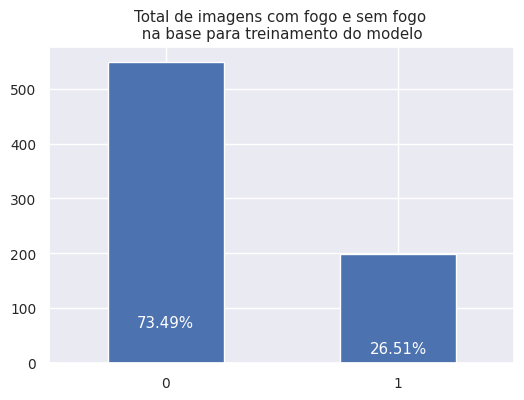

In [50]:
# Gráfico de barras com a distribuição da variável class1 usada como target

valores = dftreino['class'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize = (6, 4))
fire_count = dftreino['class'].value_counts().plot.bar(title='Total de imagens com fogo e sem fogo \n na base para treinamento do modelo ')
print((dftreino['class']).value_counts())

# Adicionar o label no topo de cada barra
for i, valor in enumerate(valores):
    ax.text(i, valor, f'{valor:.2f}%', ha='center', va='center', c='white')

plt.subplots_adjust(top=0.9)
plt.xticks(rotation=360)
plt.show()

0    80
1    32
Name: class, dtype: int64


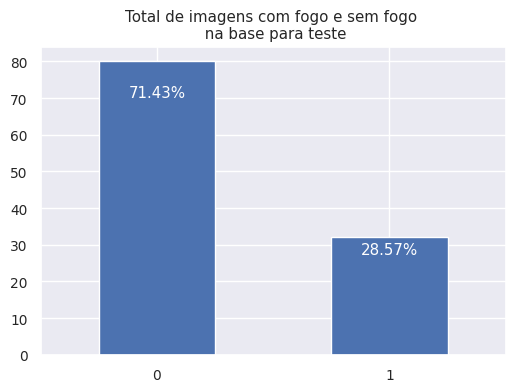

In [51]:
# Gráfico de barras com a distribuição da variável class1 usada como target base teste

valores = df_testeMod['class'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize = (6, 4))
fire_count = df_testeMod['class'].value_counts().plot.bar(title='Total de imagens com fogo e sem fogo \n na base para teste')
print((df_testeMod['class']).value_counts())

# Adicionar o label no topo de cada barra
for i, valor in enumerate(valores):
    ax.text(i, valor, f'{valor:.2f}%', ha='center', va='center', c='white')

#plt.subplots_adjust(top=0.9)
plt.xticks(rotation=360)
plt.show()

0    151
1     57
Name: class, dtype: int64


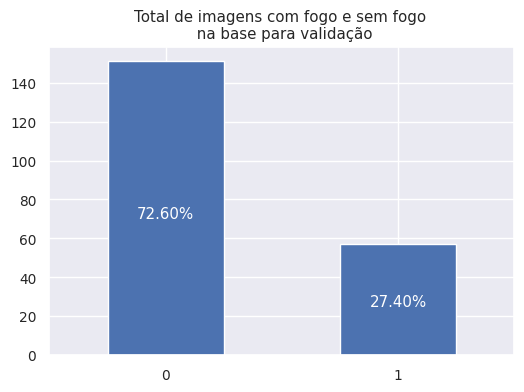

In [52]:
# Gráfico de barras com a distribuição da variável class1 usada como target base teste

valores = df_validaMod['class'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize = (6, 4))
fire_count = df_validaMod['class'].value_counts().plot.bar(title='Total de imagens com fogo e sem fogo \n na base para validação')
print((df_validaMod['class']).value_counts())

# Adicionar o label no topo de cada barra
for i, valor in enumerate(valores):
    ax.text(i, valor, f'{valor:.2f}%', ha='center', va='center', c='white')

#plt.subplots_adjust(top=0.9)
plt.xticks(rotation=360)
plt.show()

Em função de estar utilizando o datset dftreino, as imagens informadas no atributo "images" servirá como referência na selecão das imagens a serem utilizadas, ou seja, não serão usadas todas as imagens pertencentes ao diretório.

O vetor_images conterá o nome das imagens e a variável imagens receberá apenas aquelas informadas pelo vetor.

In [53]:
# Vetor com as nomes das imagens do dataset de treino

vetor_images = dftreino["images"].values

In [54]:
# Lista de arquivos de imagens presentes no diretório
imagens = [arquivo for arquivo in os.listdir(r) if arquivo in vetor_images]

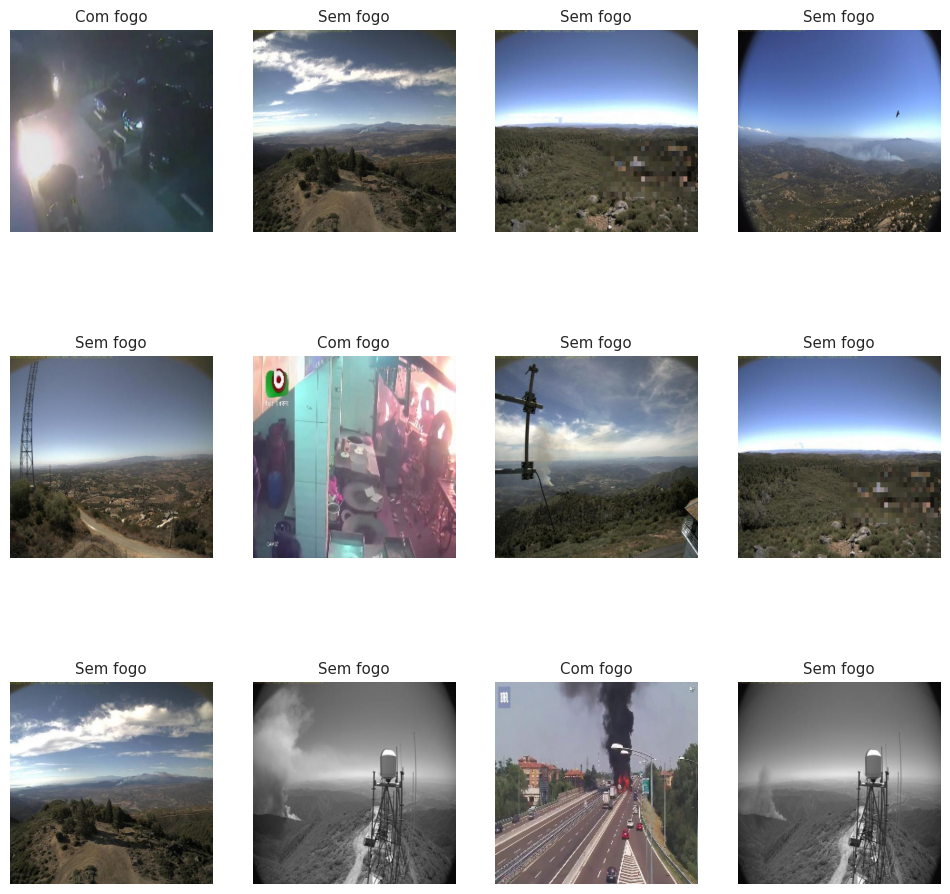

In [55]:
# Apresentando uma amostra de 12 imagens

fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Visualizando apenas 12 imagens
for i in range(12):

    sample = np.random.choice(imagens)
    img_path = r+sample
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(sample[:3])

    if sample[:3] == 'img':
      plt.title('Com fogo')
    if sample[:3] == 'ck0':
      plt.title('Sem fogo')
    else:
      plt.title('Com fogo')

plt.show()

In [56]:
train_datagen=ImageDataGenerator(validation_split=0.2, #include validation split
                                 rescale = 1.0/255,
                                 rotation_range=40,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    dftreino ,r,
    target_size=(150,150),
    batch_size=100,
    class_mode='binary',
    x_col='images',
    y_col='class_nome',
    subset='training', #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    df_validaMod ,v,
    target_size=(150,150),
    batch_size=100,
    class_mode='binary',
    x_col='images',
    y_col='class_nome',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    df_testeMod ,t,
    target_size=(150,150),
    batch_size=100,
    class_mode='binary',
    x_col='images',
    y_col='class_nome')

Found 598 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


<Figure size 1200x1200 with 0 Axes>

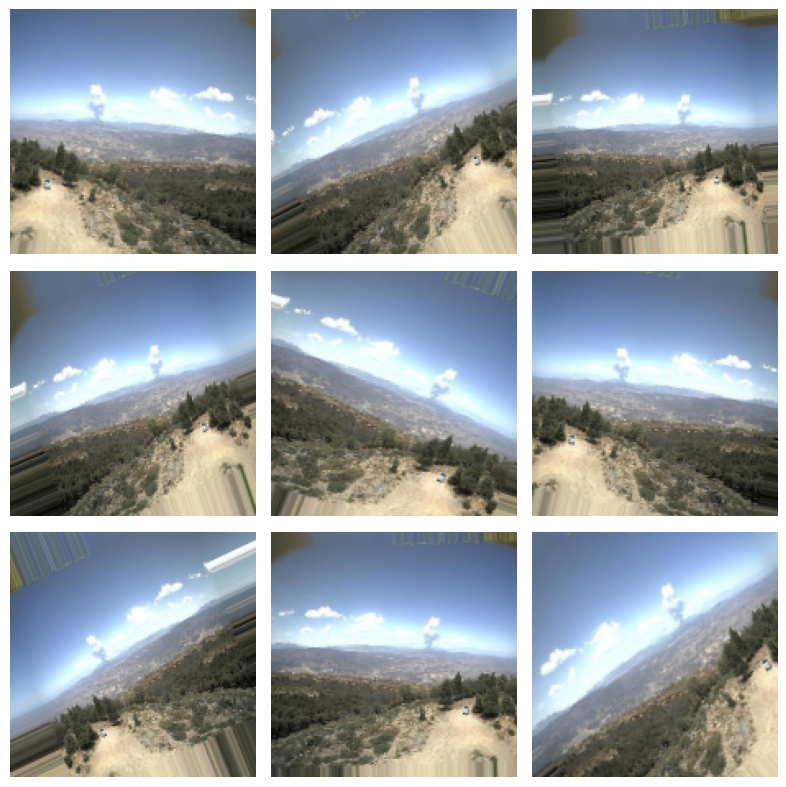

In [57]:
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Pegando um registro do dataframe
sample = dftreino.sample(n=1)

# Neste caso o tipo de classe é categorico, pois temos um exemplo com apenas uma classe
sample_generator = train_datagen.flow_from_dataframe(
    sample,
    r,
    x_col='images',
    y_col='class_nome',
    target_size=(150,150),
    class_mode='categorical'
)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

# ***5. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras***

##5.1 - Definição da arquitetura do modelo

In [58]:
model=models.Sequential()
model.add(layers.Conv2D(32 ,(3,3) , activation='relu' , input_shape=(150,150,3 ) ) )
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(64 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

In [59]:
model.add(layers.Flatten() )
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 512 ,activation='relu' ))
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 1 , activation='sigmoid' ) )

In [60]:
# Resumo da arquitetura do modelo

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# ***6. Treinamento do modelo de deep learning***

##6.1 - Compilação do modelo Keras com as configurações do treinamento

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

In [ ]:
history=model.fit_generator(train_generator,
                            epochs=10,
                            validation_data=val_generator)

Epoch 1/10


# ***7. Execução do modelo treinado em um subconjunto das imagens de teste***

In [ ]:
count = 0
y_pred = list()
y_true = list()
class_names = ['Com fogo', 'Sem fogo']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'Sem fogo' if prediction >= 0.5 else 'Com fogo'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.figure(figsize=(3, 3))
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)

# ***8. Avaliação do modelo de Deep Learning***

In [ ]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

In [ ]:
class_names = ['Sem fogo', 'Com fogo']
print("Classes utilizadas:", class_names)

# Restante do seu código
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      normalize=False,
                      title='Matriz real x predição')

plt.show()

In [ ]:
labels = ['Sem fogo', 'Com fogo']
print(classification_report(y_true, y_pred, target_names=labels))

# ***9. Execução do modelo treinado em um subconjunto das imagens de teste***

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'datasets/dogs_vs_cats/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

# ***10. Teste do Modelo exportado***

In [ ]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

In [ ]:
count = 0
y_pred = list()
y_true = list()
class_names = ['Com fogo', 'Sem fogo']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = loaded_model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'Sem fogo' if prediction >= 0.5 else 'Com fogo'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)